# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- compute distance between 2 ghost spots (distance + flux + size?)
- compute distance between 2 series of ghosts spots


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import find_nearest_ghost, match_ghosts, compute_reduced_distance
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0.02

Direct path is number 28
  central impact point is (0.099478, -0.000025)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 682.8328


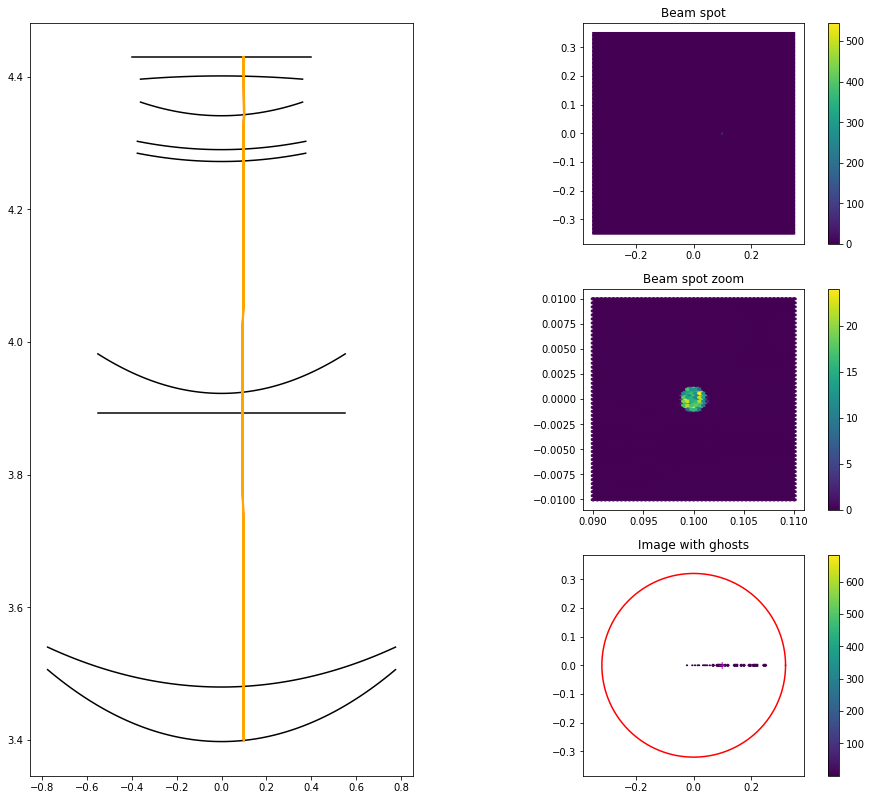

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


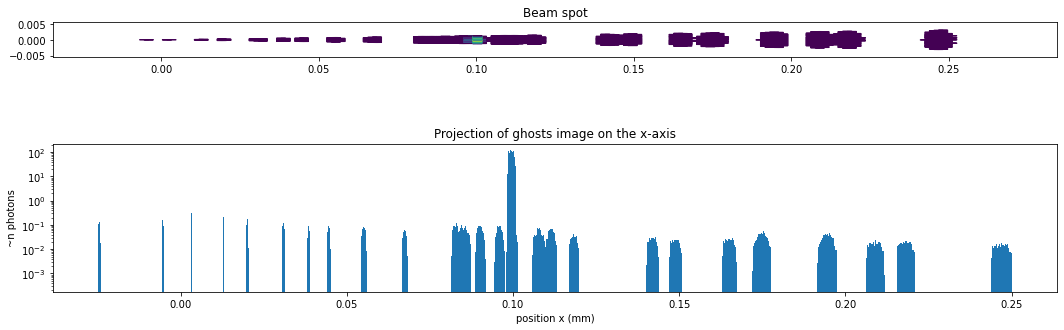

0

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


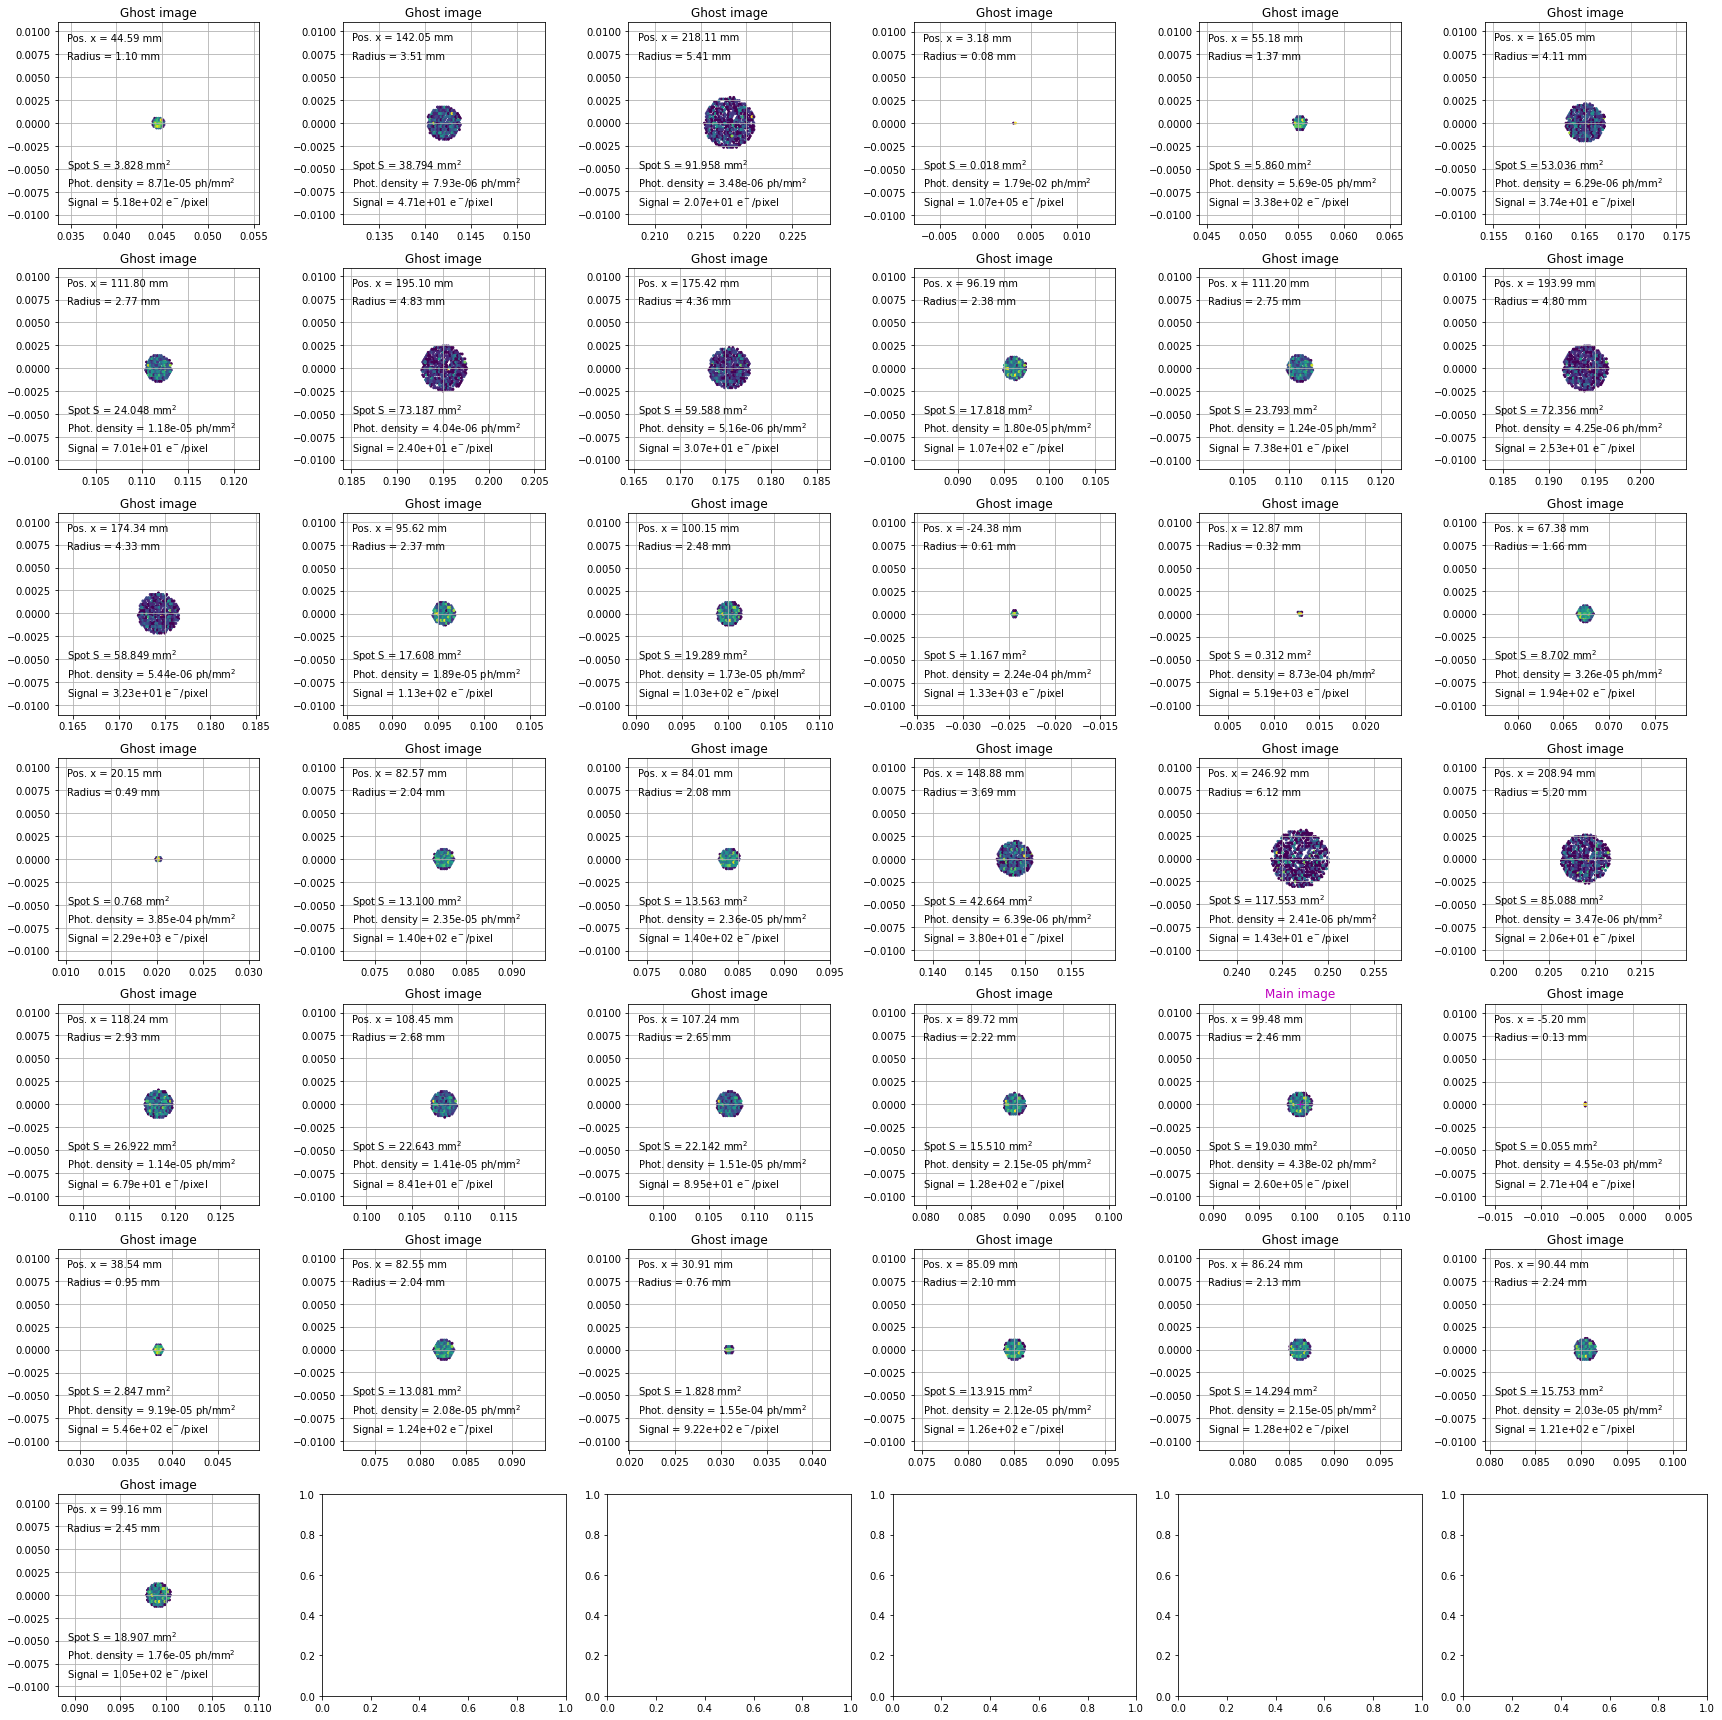

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1)
data_frame_1.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,pos_y,width_x,width_y,radius,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085093,-2.175627e-05,0.002100,0.002109,0.002105,13.915415,126.172482
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086241,-2.204969e-05,0.002128,0.002138,0.002133,14.293834,127.896880
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",-0.005197,1.328345e-06,0.000136,0.000129,0.000133,0.055212,27054.476620
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.038537,-9.853202e-06,0.000949,0.000955,0.000952,2.846980,546.302053
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082552,-2.110652e-05,0.002035,0.002046,0.002041,13.080681,123.804030
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.030906,-7.901953e-06,0.000760,0.000766,0.000763,1.828056,922.408905
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090442,-2.312357e-05,0.002237,0.002242,0.002239,15.753032,120.834893
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099161,-2.535288e-05,0.002448,0.002458,0.002453,18.906562,104.831500
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.111200,-2.843088e-05,0.002748,0.002756,0.002752,23.792528,73.793861
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.193991,-4.959867e-05,0.004790,0.004809,0.004799,72.355998,25.265863


Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


/home/bregeon/Rubin/CCOB/ghosts/ghosts/plotter.py:181: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


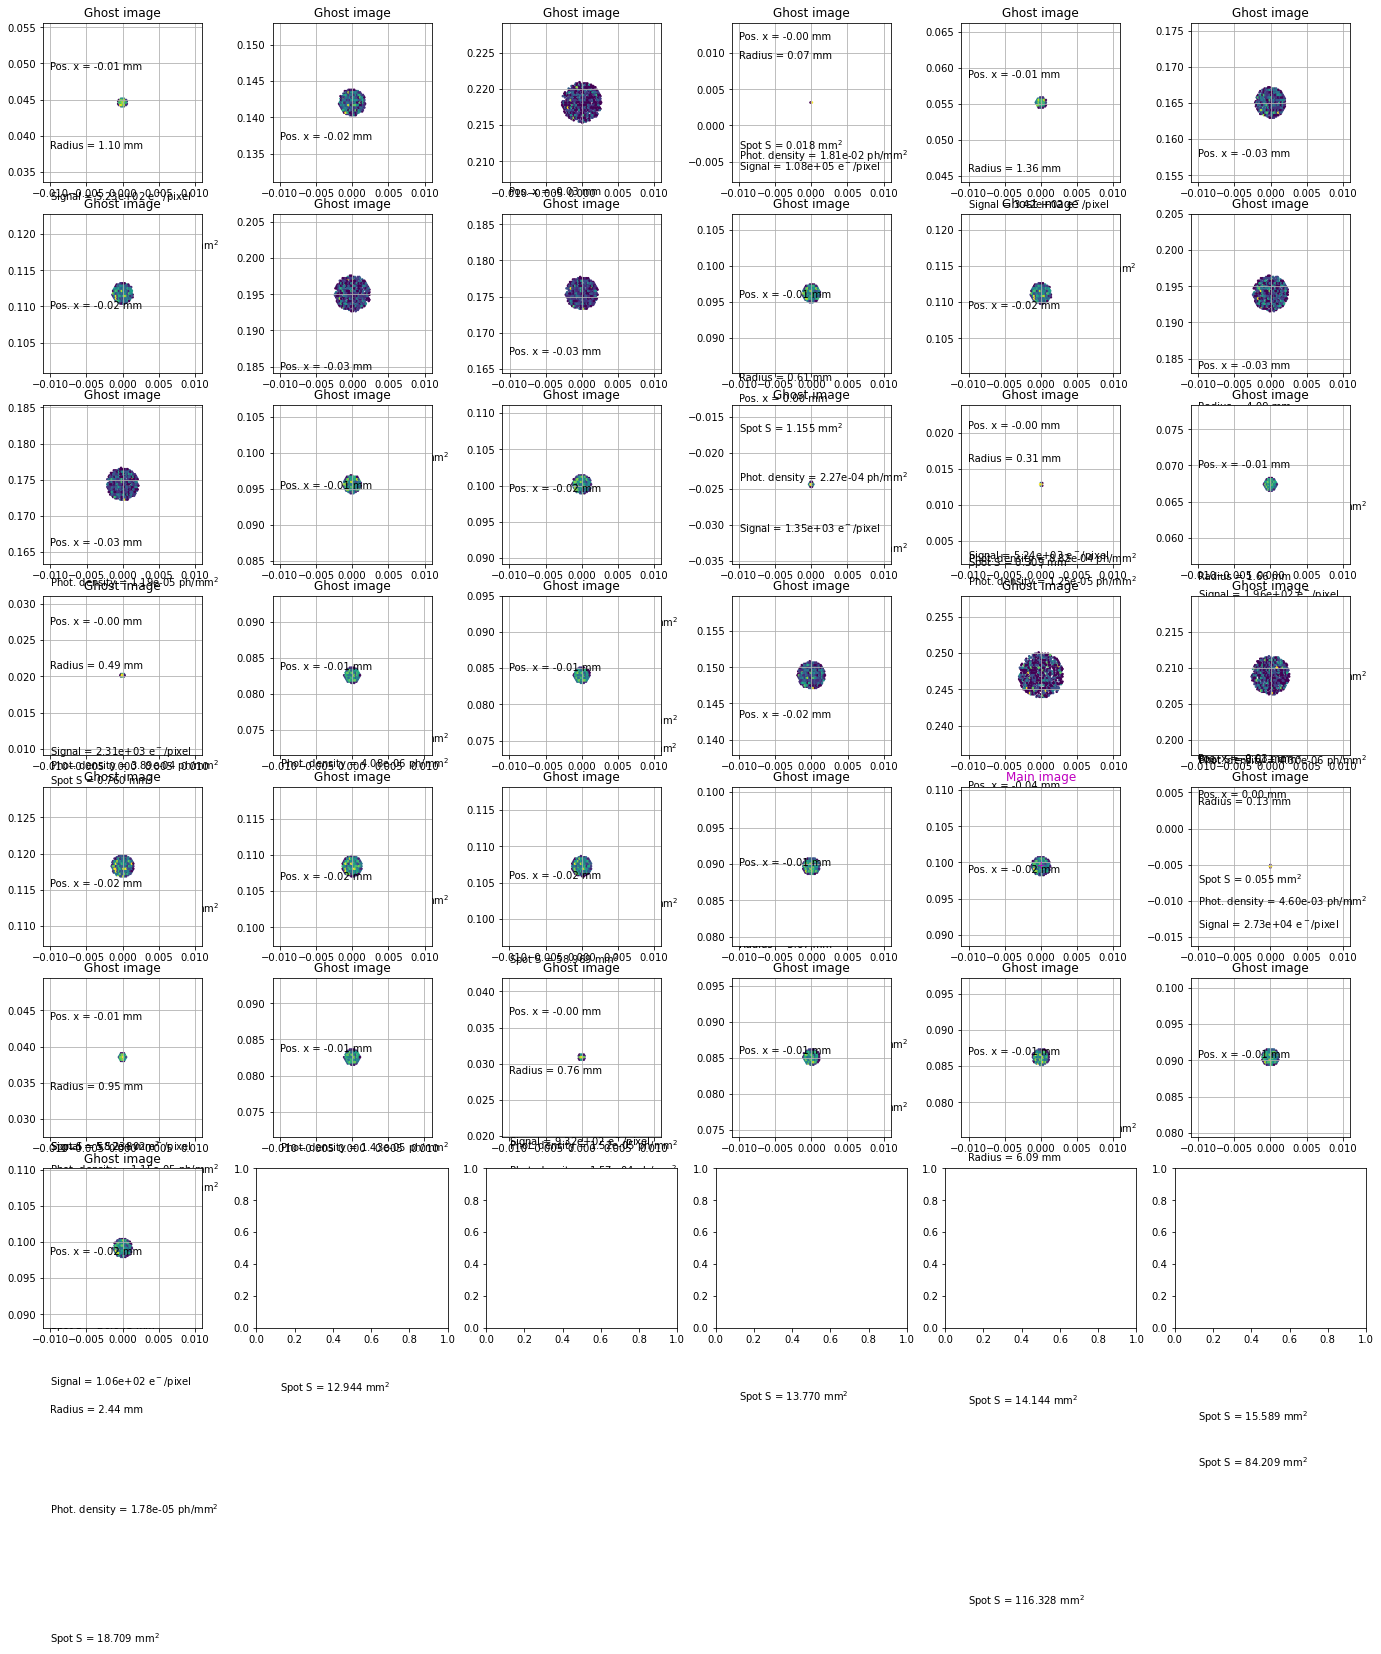

In [10]:
# Run another simulation with beam config 2
traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_2)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_2)
data_frame_2.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,pos_y,width_x,width_y,radius,surface,pixel_signal
33,2,1000,0.0,0.1,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",-1.308150e-05,0.085101,0.002079,0.002108,0.002094,13.769890,127.505925
34,2,1000,0.0,0.1,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",-1.325793e-05,0.086249,0.002107,0.002137,0.002122,14.144355,129.248501
29,2,1000,0.0,0.1,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",7.985159e-07,-0.005197,0.000127,0.000137,0.000132,0.054666,27324.516197
30,2,1000,0.0,0.1,0.00125,0.0,0.0,30,"(Detector, L1_exit)",-5.924539e-06,0.038541,0.000942,0.000952,0.000947,2.817139,552.088812
31,2,1000,0.0,0.1,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",-1.269088e-05,0.082559,0.002017,0.002043,0.002030,12.943735,125.113887
32,2,1000,0.0,0.1,0.00125,0.0,0.0,32,"(Detector, L2_exit)",-4.751319e-06,0.030909,0.000755,0.000762,0.000759,1.808867,932.194051
35,2,1000,0.0,0.1,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",-1.390352e-05,0.090451,0.002210,0.002245,0.002228,15.588604,122.109460
36,2,1000,0.0,0.1,0.00125,0.0,0.0,36,"(Detector, L3_exit)",-1.524402e-05,0.099170,0.002423,0.002458,0.002440,18.708934,105.938869
10,2,1000,0.0,0.1,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",-1.709470e-05,0.111210,0.002717,0.002758,0.002738,23.543982,74.572879
11,2,1000,0.0,0.1,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",-2.982239e-05,0.194010,0.004740,0.004808,0.004774,71.599631,25.532767


In [12]:
i_min, dist = find_nearest_ghost(data_frame_1.xs(2), data_frame_1)
print(i_min, dist, '\n', data_frame_1.xs(i_min))

2 0.0 
 config                           1
n_photons                     1000
beam_x                         0.1
beam_y                           0
beam_width                 0.00125
beam_theta                     0.0
beam_phi                       0.0
index                            2
name            (L2_exit, L1_exit)
pos_x                     0.218112
pos_y                    -0.000056
width_x                   0.005414
width_y                   0.005406
radius                     0.00541
surface                  91.958443
pixel_signal             20.699741
Name: 2, dtype: object


In [13]:
match = match_ghosts(data_frame_1, data_frame_2)
match

,ghost_1,ghost_2,distance
0,0,3,0.044705
1,1,3,0.142084
2,2,3,0.218136
3,3,3,0.004497
4,4,3,0.055271
5,5,3,0.165077
6,6,3,0.111842
7,7,3,0.195131
8,8,3,0.175452
9,9,3,0.096243


In [14]:
compute_reduced_distance(match)

0.014435347976900841